# 20기 Time Series 정규세션 과제

### Electric_Production.csv 데이터를 활용하여 자유롭게 시계열분석을 진행해주세요.
첨부한 '시계열자료_실습.ipynb' 코드를 참고하셔도 좋습니다.


### Box-Jenkins 방법론
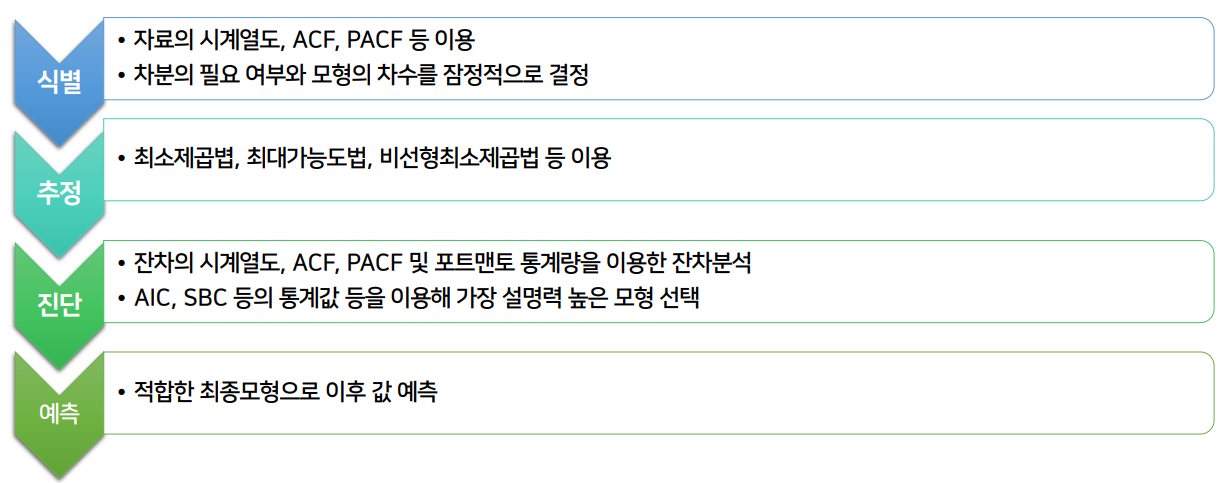

### Prophet
튜토리얼 : https://hyperconnect.github.io/2020/03/09/prophet-package.html

## 라이브러리 불러오기

In [1]:
import warnings
warnings.filterwarnings("ignore") 
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from pandas import Timestamp
from statsmodels.tsa.arima_model import ARIMAResults

In [2]:
import warnings
warnings.filterwarnings("ignore") 

## 데이터 불러오기

In [3]:
samsung_df = yf.download('005930.KS',
                      start='2020-01-01',
                      end='2021-04-21',
                      progress=False)

samsung_df = samsung_df[["Close"]]

samsung_df = samsung_df.reset_index()

samsung_df.columns = ['day', 'price']

samsung_df['day'] = pd.to_datetime(samsung_df['day'])

samsung_df.index = samsung_df['day']
samsung_df.set_index('day', inplace=True)

samsung_df

,price
day,
2020-01-02,55200.0
2020-01-03,55500.0
2020-01-06,55500.0
2020-01-07,55800.0
2020-01-08,56800.0
...,...
2021-04-14,84000.0
2021-04-15,84100.0
2021-04-16,83900.0


In [4]:
samsung_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 322 entries, 2020-01-02 to 2021-04-20
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   322 non-null    float64
dtypes: float64(1)
memory usage: 5.0 KB


# 1. 식별

### 1-1. 시계열 그래프 시각화

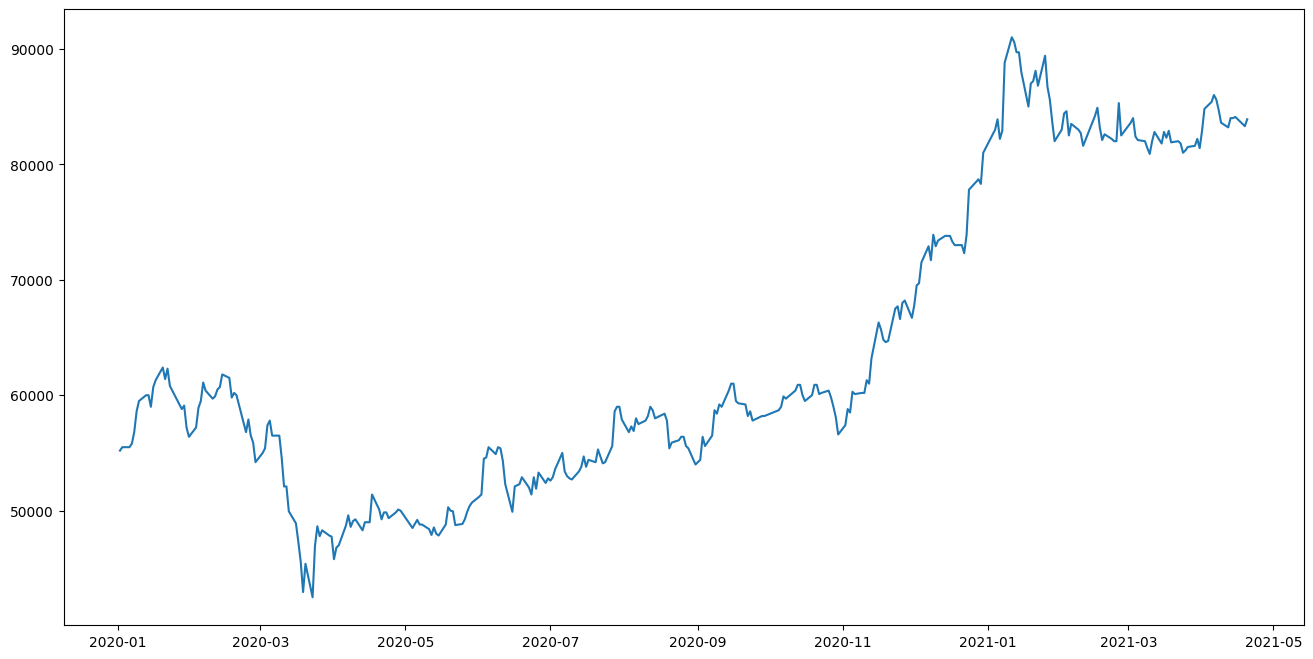

In [5]:
plt.figure(figsize=(16,8))
plt.plot(samsung_df.index, samsung_df["price"], linestyle="-")
plt.xlabel=('Day')
plt.ylabel=('Price')
plt.show()

##### 시각화 자료를 통해 정상성을 만족하지 않음을 유추해 볼 수 있습니다.

### 1-2. Rolling Statistics Plot : 시계열 데이터의 추세와 변동성을 더 잘 이해하기 위해 이동 통계량을 그래프로 표현하는 방법

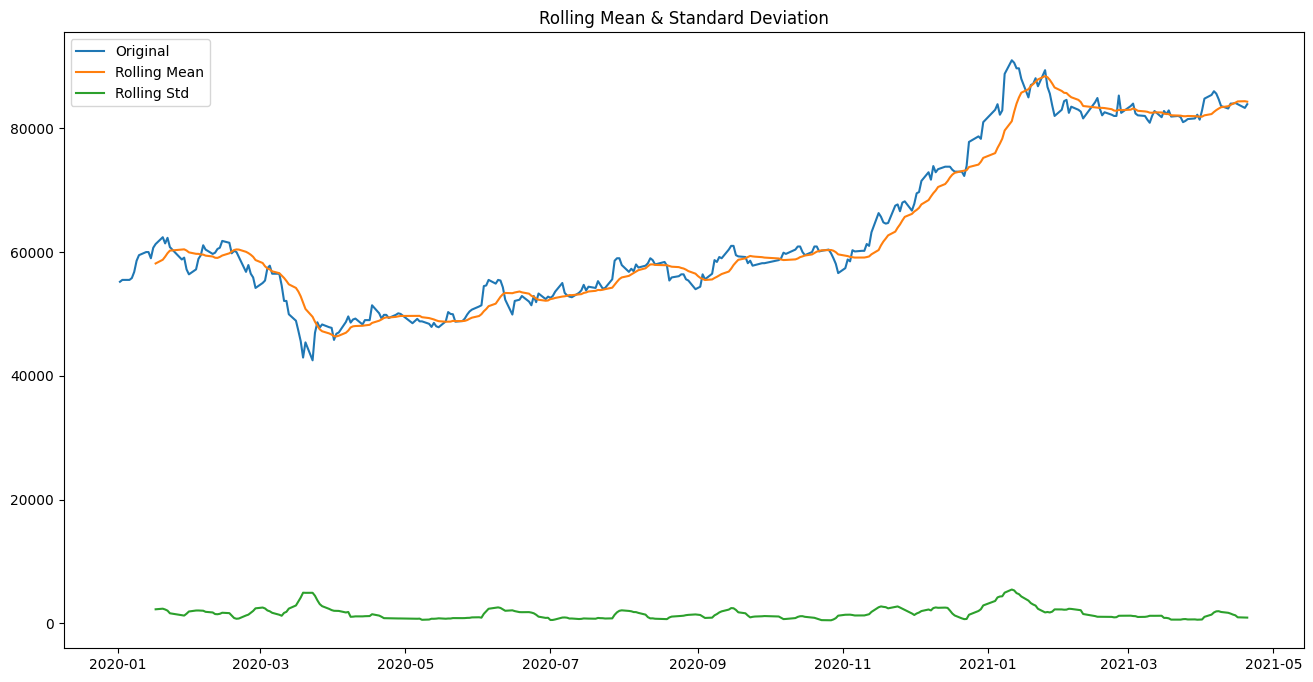

In [6]:
# 이동평균과 이동표준편차 계산
rolling_mean = samsung_df["price"].rolling(window=12).mean()
rolling_std = samsung_df["price"].rolling(window=12).std()

# 그래프로 표시
plt.figure(figsize=(16, 8))
plt.plot(samsung_df["price"], label='Original')
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(rolling_std, label='Rolling Std')
plt.xlabel=('Day')
plt.ylabel=('Price')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

##### 그래프에서 이동평균 곡선이 추세성분을 가지고 있습니다. 한편으로 이동 표준편차 곡선은 비교적 안정적인 것으로 나타났습니다. 그러나 정상성을 만족시키기 위해서는 이동평균과 이동표준편차 둘 다 시간에 따라 변하지 않거나 안정적이어야 합니다. 즉, 그래프에서 두 곡선이 x축과 평행한 형태를 가져야 합니다. 그러므로 추세성분과 변동성의 불안정함(정상성을 만족하지 않음)을 의심할 수 있습니다.

### 1-3. Dickey-Fuller Test : 시계열 데이터가 정상성을 가지는지 여부를 검정하는 통계적 검정 방법

##### H0(데이터가 비정상성을 가짐) VS H1(데이터가 정상성을 가짐)

In [7]:
result = adfuller(samsung_df["price"])

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])
print('Is stationary:', result[1] <= 0.05)

ADF Statistic: -0.2121894796632919
p-value: 0.9370529809409829
Critical Values: {'1%': -3.450886958636161, '5%': -2.870586350823483, '10%': -2.5715897843576827}
Is stationary: False


##### 유의수준 0.05 하에서 귀무가설을 기각할 수 없으므로 데이터는 비정상성을 가짐(정상성을 만족하지 않음) 이라고 말 할 수 있습니다.

### 1-4. ACF와 PACF 그래프

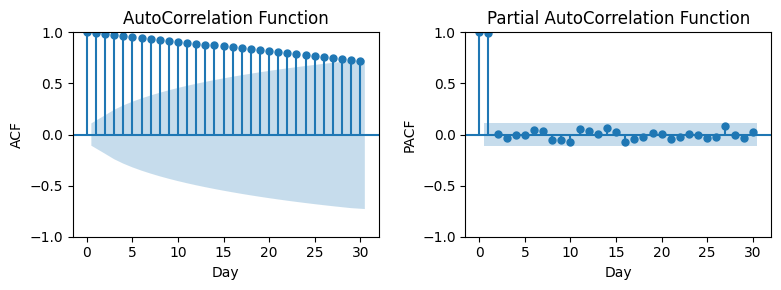

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

# ACF 그래프
plot_acf(samsung_df["price"], lags=30, alpha=0.05, ax=ax[0])
ax[0].set_xlabel('Day')
ax[0].set_ylabel('ACF')
ax[0].set_title('AutoCorrelation Function')

# PACF 그래프
plot_pacf(samsung_df["price"], lags=30, alpha=0.05, ax=ax[1])
ax[1].set_xlabel('Day')
ax[1].set_ylabel('PACF')
ax[1].set_title('Partial AutoCorrelation Function')

plt.tight_layout()

plt.show()

##### 위 자료를 통해 정상성을 만족하지 않음을 파악할 수 있습니다.

##### 위의 결과들을 통해 삼성 주가 시계열 데이터는 정상성을 만족하지 못한다고 판단할 수 있습니다. 따라서 모형의 정상성을 만족하기 위해 분산안정화 변환(로그변환) 혹은 차분을 해줘야 합니다.

In [9]:
# 로그변환 & 1차 차분
log_df = np.log(samsung_df.price)
log_samsung_df = log_df.diff(1).dropna()

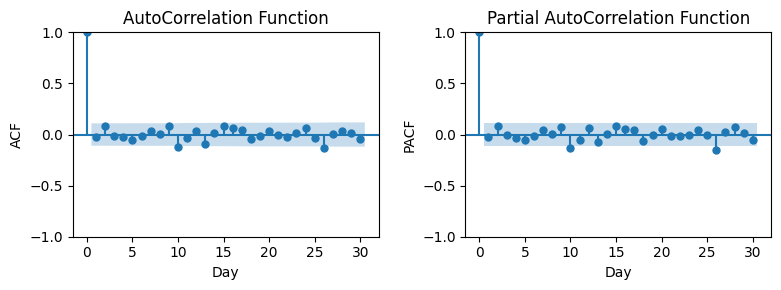

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

# ACF 그래프
sm.graphics.tsa.plot_acf(log_samsung_df, lags=30, alpha=0.05, ax=ax[0])
ax[0].set_xlabel('Day')
ax[0].set_ylabel('ACF')
ax[0].set_title('AutoCorrelation Function')

# PACF 그래프
sm.graphics.tsa.plot_pacf(log_samsung_df, lags=30, alpha=0.05, ax=ax[1])
ax[1].set_xlabel('Day')
ax[1].set_ylabel('PACF')
ax[1].set_title('Partial AutoCorrelation Function')

plt.tight_layout()

plt.show()

# 2. 추정

In [11]:
model = auto_arima(log_df, 
                   d = 1,   # 차분차수=1 
                   start_p = 1,
                   max_p = 3,
                   start_q = 1,
                   max_q = 3,
                   m = 30,
                   stepwise = True,   #스텝바이스 탐색 사용
                   seasonal = False,
                   trace = True)   #계절성 고려 여부
model.fit(log_df)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1591.937, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1595.409, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1593.556, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1593.535, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1596.052, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.595 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [12]:
model = auto_arima(samsung_df['price'], 
                   d = 1,
                   D = 1,
                   m = 30, 
                   start_p = 1,
                   max_p = 3,
                   start_q = 1,
                   max_q = 3, 
                   stepwise = True,
                   seasonal = True,
                   trace = True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[30]             : AIC=inf, Time=22.21 sec
 ARIMA(0,1,0)(0,1,0)[30]             : AIC=5192.249, Time=0.34 sec
 ARIMA(1,1,0)(1,1,0)[30]             : AIC=5163.201, Time=2.33 sec
 ARIMA(0,1,1)(0,1,1)[30]             : AIC=5144.504, Time=7.82 sec
 ARIMA(0,1,1)(0,1,0)[30]             : AIC=5193.641, Time=0.29 sec
 ARIMA(0,1,1)(1,1,1)[30]             : AIC=inf, Time=16.03 sec
 ARIMA(0,1,1)(0,1,2)[30]             : AIC=5131.767, Time=27.71 sec
 ARIMA(0,1,1)(1,1,2)[30]             : AIC=inf, Time=36.97 sec
 ARIMA(0,1,0)(0,1,2)[30]             : AIC=5130.348, Time=20.38 sec
 ARIMA(0,1,0)(0,1,1)[30]             : AIC=5143.019, Time=5.70 sec
 ARIMA(0,1,0)(1,1,2)[30]             : AIC=inf, Time=11.55 sec
 ARIMA(0,1,0)(1,1,1)[30]             : AIC=inf, Time=7.18 sec
 ARIMA(1,1,0)(0,1,2)[30]             : AIC=5142.035, Time=14.92 sec
 ARIMA(1,1,1)(0,1,2)[30]             : AIC=5133.597, Time=45.61 sec
 ARIMA(0,1,0)(0,1,2)[30] intercept  

##### AIC를 이용해 가장 설명력 높은 모형을 살펴봤더니 AIC가 가장 작은 ARIMA(0,1,0)(0,1,2)[30] 모형이 최종 모형이 되었습니다.

# 3. 진단

In [13]:
print(model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  322
Model:             SARIMAX(0, 1, 0)x(0, 1, [1, 2], 30)   Log Likelihood               -2562.174
Date:                                 Sat, 26 Aug 2023   AIC                           5130.348
Time:                                         23:36:19   BIC                           5141.368
Sample:                                              0   HQIC                          5134.762
                                                 - 322                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L30      -0.4259      0.023    -18.772      0.000      -0.470      -0

##### 위에 주어진 결과로부터 Box-Jenkins 방법론의 모델을 진단해보겠습니다.

### 3-1. Ljung-Box : 잔차의 자기상관을 평가하는 통계적 검정

##### 위에는 Ljung-Box 검정 결과가 주어져 있는데, Ljung-Box (L1) (Q) 값이 0.02 이며, 이 값이 유의미하게 작다면 잔차에 자기상관이 존재할 수 있다는 것을 나타냅니다. 여기서는 Prob(Q) 값이 0.88로 크게 나오므로, 잔차에 유의미한 자기상관이 없을 가능성이 높습니다.

### 3-2. Jarque-Bera Test : 정규성 검정

##### 위에는 Jarque-Bera (JB) 값이 28.61이며, 이 값이 유의미하게 크다면 잔차가 정규분포를 따르지 않을 수 있다는 것을 나타냅니다. 여기서는 Prob(JB) 값이 0.00으로 작게 나오므로, 잔차가 정규분포를 따르지 않을 가능성이 높습니다.

### 3-3. Standardized residual plot, Histogram plus estimated density plot,  Normal Q-Q, Correlogram

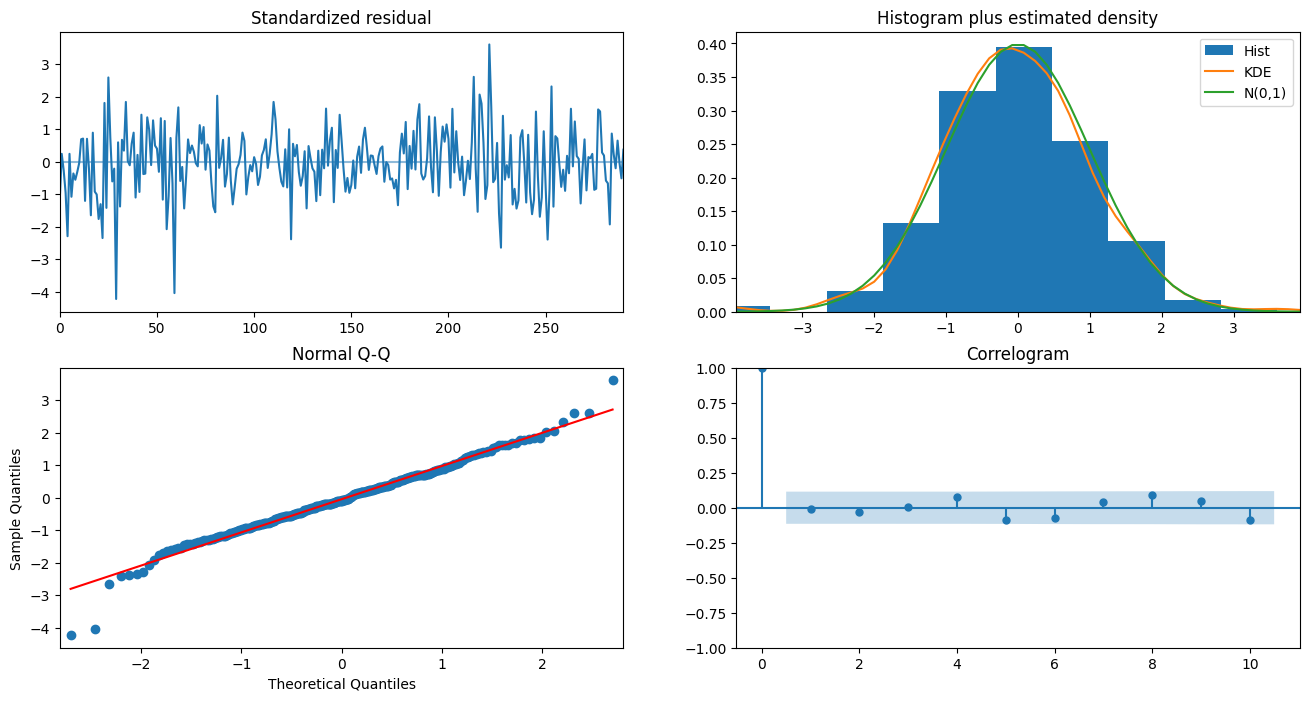

In [14]:
model.plot_diagnostics(figsize=(16, 8))
plt.show()

##### Standardized residual plot, Correlogram : 자기상관이 없음을 확인 
##### Histogram plus estimated density plot, Normal Q-Q : 정규성을 따르지 않음을 확인

# 4. 예측

In [15]:
# 최적의 모델 설정
order = (0, 1, 0)
seasonal_order = (0, 1, 2, 30)

# 모델을 생성하고 학습
model = sm.tsa.arima.ARIMA(log_df, order=order, seasonal_order=seasonal_order)
model_fit = model.fit()

# 예측을 수행
forecast = model_fit.predict()
forecast

day
2020-01-02     0.000000
2020-01-03    10.918718
2020-01-06    10.924138
2020-01-07    10.924138
2020-01-08    10.929529
                ...    
2021-04-14    11.339411
2021-04-15    11.334815
2021-04-16    11.331330
2021-04-19    11.338126
2021-04-20    11.334398
Name: predicted_mean, Length: 322, dtype: float64

In [16]:
# Z-Score를 계산하여 이상치를 확인하고, 특정 임계값을 넘는 이상치를 제거하는 함수
def remove_outliers(data, threshold=3):
    z_scores = np.abs((data - data.mean()) / data.std())
    filtered_data = data[z_scores <= threshold]
    return filtered_data

# Z-Score 계산 및 이상치 제거
filtered_forecast = remove_outliers(forecast)

# 업데이트된 예측값 출력
print("업데이트된 예측값:")
print(filtered_forecast)

업데이트된 예측값:
day
2020-01-03    10.918718
2020-01-06    10.924138
2020-01-07    10.924138
2020-01-08    10.929529
2020-01-09    10.947292
                ...    
2021-04-14    11.339411
2021-04-15    11.334815
2021-04-16    11.331330
2021-04-19    11.338126
2021-04-20    11.334398
Name: predicted_mean, Length: 320, dtype: float64


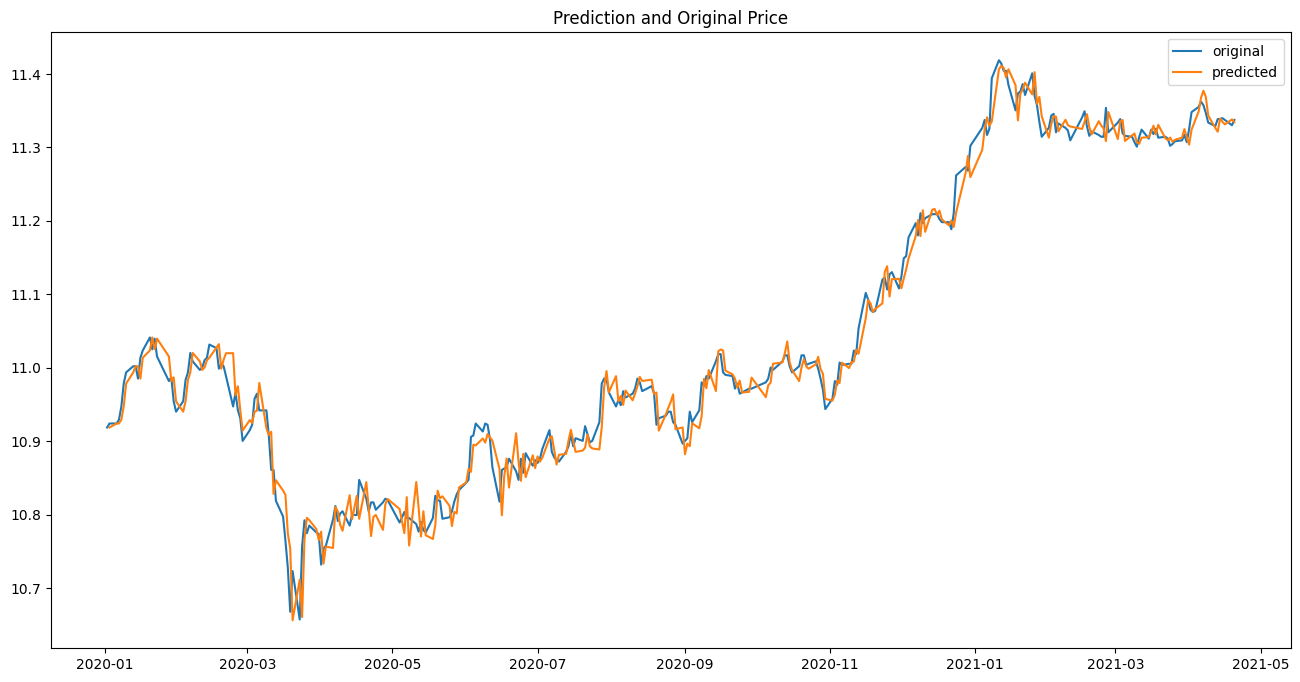

In [17]:
plt.figure(figsize=(16,8))
plt.plot(log_df, label = 'original')
plt.plot(filtered_forecast, label = 'predicted')
plt.title('Prediction and Original Price')
plt.legend()
plt.show()

##### 위 그래프를 통해 예측값과 실제값을 직접적으로 비교해볼 수 있고, 잘 예측해나가고 있음을 확인할 수 있습니다. 주어진 데이터 이후에 값들도 추가적으로 예측해보면 아래와 같습니다. 

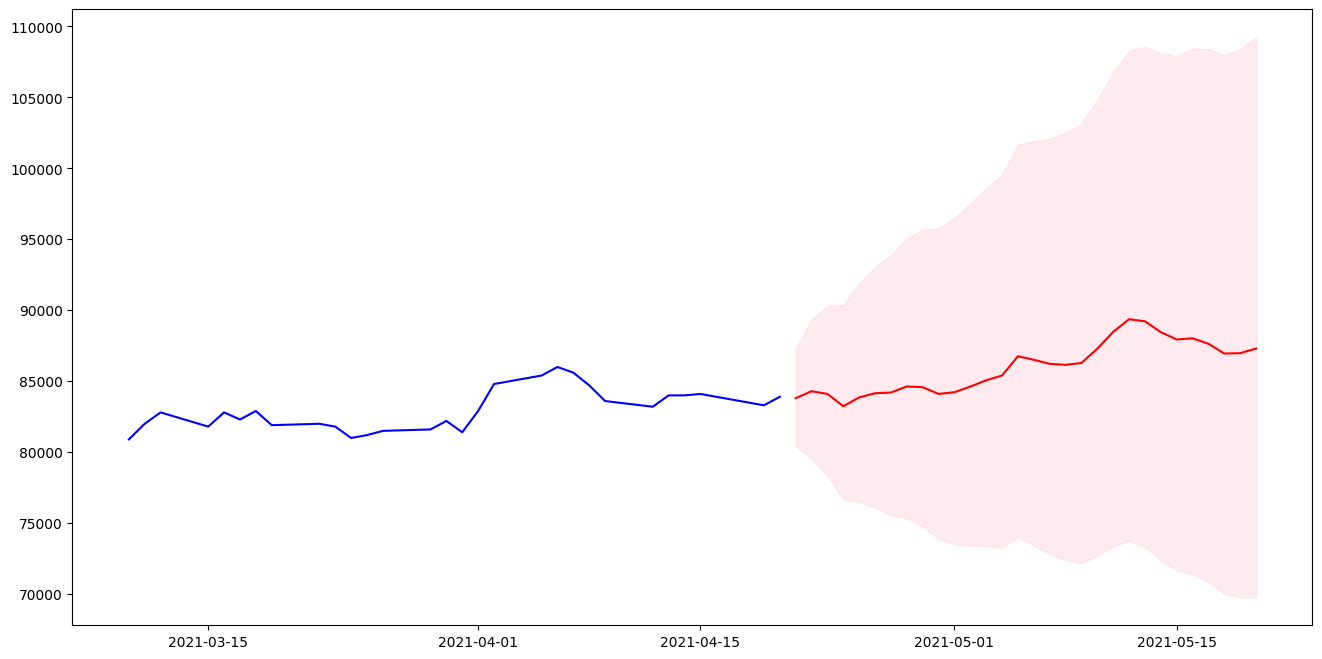

In [18]:
# 예측을 수행
forecast_steps = 30
forecast = model_fit.get_forecast(steps=forecast_steps)

# 예측 결과와 신뢰구간
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# 원래 시계열 데이터
original_data = np.exp(log_df)[-forecast_steps:]

# ARIMA 모델을 생성하고 학습
model = sm.tsa.SARIMAX(log_df, order=order, seasonal_order=seasonal_order)
model_fit = model.fit()

# 로그 변환을 원래 데이터 스케일로 변환
forecast_mean = np.exp(forecast.predicted_mean)
forecast_conf_int = np.exp(forecast.conf_int())

# 원래 데이터의 마지막 날짜
last_date = original_data.index[-1]

# 예측한 기간의 날짜 범위를 생성
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps)

# 예측값의 시계열 그래프
plt.figure(figsize=(16, 8))
plt.plot(original_data.index, original_data, label='Actual', color='blue')
plt.plot(forecast_dates, forecast_mean, label='Forecast', color='red')

# 예측 신뢰구간을 그래프로 표시
plt.fill_between(forecast_dates, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)
